# CorEx (Correlation Explanation) for Topic Modeling
- [CorEx reference](https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb)
- unsupervised and semi-supervised topic modeling

In [ ]:
# # Install CorEx 
# !pip install corextopic
# !pip install networkx

In [3]:
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [1]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## CorEx Topic Model

The CorEx topic model provides topic words which are those with the highest *mutual information* with the topic (rather than those with highest probability within the topic as with LDA). 

The main parameters of the CorEx topic model are:
- n_hidden: number of topics ("hidden" latent topics)
- words: words that label the columns of the doc-word matrix (optional)
- docs: document labels that label the rows of the doc-word matrix (optional)
- max_iter: number of iterations to run through the update equations (optional; defaults to 200)
- verbose: if verbose=1, CorEx will print the topic Total Correlation (TC) with each iteration
- seed: random number seed to use for model initialization (optional)

## Total Correlation Measures
Overall Total Correlation (OTC) is the measure which CorEx maximizes when constructing the topic model. OTC is a sum of the Total Correlation (TC) *per each topic*; reported in nats.

For an unsupervised CorEx topic model, the topics are sorted from high to low according to their TC.  
For an anchored CorEx topic model, the topics are not sorted; they are outputted with the anchored topics appearing first. 

## Semi-Supervised CorEx Topic Model: Anchoring
Anchoring provides a way to guide the topic model towards specific subsets of words to explore

There are many way to anchor, including:
- anchor a single word to a single topic
- anchor multiple group of words to multiple topics
- anchor with single words AND groups of words

Anchor strength: controls how much weight CorEx puts towards maximizing the mutual information between anchor words and their respective topics. Should always be greater than 1. Empirically, setting anchor strength between 1.5-3 appears to nudge the topic model towards the anchor words. Anchor strength greater than 5 strongly enforces that the CorEx topic model find a topic associated with the anchor words.

## Functions

In [1]:
def unsupervised_topic_modeling(num_topics, column_labels, seed_num, doc_word_matrix):
    '''
    Function that uses CorEx to train a topic model and generate the number of topics indicated by num_topics.  
    
    Prints 1) the Overall Total Correlation (OTC) measure and 2) all the topics. 
    
    Returns the topic model.  
    '''
    
    # train model 
    topic_model = ct.Corex(n_hidden=num_topics, words=column_labels, seed=seed_num)
    topic_model.fit(doc_word_matrix, words=column_labels)
    
    # the measure which CorEx maximizes when constructing the topic model; reported in nats
    print(f'Overall Total Correlation: {topic_model.tc.round(3)}')
    
    # print all topics from CorEx topic model
    topics = topic_model.get_topics()
    for n, topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
    
    return topic_model

In [9]:
def topic_tc_chart(topic_model):
    '''
    Outputs bar chart to visualize the topic Total Correlations (TC).
    '''
    plt.figure(figsize=(10,5))
    x_positions = range(topic_model.tcs.shape[0]) # number of topics
    bar_labels = range(topic_model.tcs.shape[0]) 
    plt.bar(x_positions, topic_model.tcs, width=0.5)  
    plt.xticks(x_positions, bar_labels)
    plt.xlabel('Topic', fontsize=16)
    plt.ylabel('Total Correlation (nats)', fontsize=16);

In [2]:
def anchored_topic_modeling(num_topics, column_labels, seed_num, doc_word_matrix, anchor_words, anchor_strength=6):
    '''
    Function that uses CorEx to train an anchored topic model and generate the number of topics indicated by num_topics.
    
    Input must include one or more anchor word in list format (list of lists if more than one anchored topic). 
    
    Prints 1) the Overall Total Correlation (OTC) measure and 2) all the topics. 
    
    Returns the anchored topic model.  
    '''
    
    # train model 
    anchored_topic_model = ct.Corex(n_hidden=num_topics, words=column_labels, seed=seed_num)
    anchored_topic_model.fit(doc_word_matrix, words=column_labels, anchors=anchor_words, anchor_strength=anchor_strength)
    
    # the measure which CorEx maximizes when constructing the topic model; reported in nats
    print(f'Overall Total Correlation: {anchored_topic_model.tc.round(3)}')
    
    # print all topics from CorEx topic model
    topics = anchored_topic_model.get_topics()
    for n, topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))
    
    return anchored_topic_model

## Load data

In [4]:
# will take 1-2 minutes to load pickle
df_spacy_debt = pd.read_pickle('df_clean_spacy_debt.pkl')
df_spacy_debt.head()

,spacy_doc,Company,Issue,clean_spacy_doc2
0,"(I, received, an, alert, from, , on, , abou...","TRANSUNION INTERMEDIATE HOLDINGS, INC.",Attempts to collect debt not owed,receive alert collections account credito...
1,"(See, uploaded, document, dated, , ;, CHASE, ...",JPMORGAN CHASE & CO.,Took or threatened to take negative or legal a...,uploaded document date chase bank unlawfully...
2,"(On, , I, pulled, my, credit, report, and, sa...",Monterey Financial Services LLC,Written notification about debt,pull credit report see monterey financial se...
3,"(My, , (, , ), Account, number, for, Interne...",AFNI INC.,Written notification about debt,account number internet service pay outsta...
4,"(AMCOL, Systems, (, a, debt, collector, ), rep...","AMCOL Systems, Inc.",Took or threatened to take negative or legal a...,amcol systems debt collector report debt credi...


## CountVectorizer
- the topic model assumes input is in the form of a doc-word matrix (rows are documents; columns are binary counts)
- vectorize data (unigrams and bi-grams) and take top 20,000 grams
- note: CorEx topic model uses **binary count vectors** as input

In [5]:
cv = CountVectorizer(max_features=20000,
                     ngram_range=(1,2),
                     min_df=3, 
                     max_df=0.8,
                     binary=True)

doc_word = cv.fit_transform(df_spacy_debt['clean_spacy_doc2'])
doc_word.shape # n_docs x m_words

(18156, 20000)

In [6]:
# get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(cv.get_feature_names()))

## Unsupervised CorEx Topic Model

In [22]:
topic_model = unsupervised_topic_modeling(20, words, 52, doc_word)
topic_model

Overall Total Correlation: 53.766
0: shall,require,evidence,sec,defamation,title,obligation,report company,claim dispute,mark find
1: standard information,sure quickly,present record,petition sure,right petition,figure display,precisely balance,credit figure,demand accordance,wrong sure
2: federal,follow,law,creditor,party,provide follow,license,fdcpa,include,allege
3: pay,payment,month,go,year,get,time,money,want,later
4: fee,interest,charge,statement,email,offer,issue,balance,customer,able
5: provide,validation,request,proof,signature,copy,verification,contract,validate,debt
6: speak,ask,say,representative,contact,know,hang,explain,supervisor,give
7: file,complaint,claim,action,notice,date,respond,day,office,agency
8: act,fair,fair debt,reporting act,practices,practices act,collection practices,credit reporting,fair credit,reporting
9: section,accordance,item,record,demand,cause,subsection,civil,fully,collection debt
10: credit report,credit,report,credit bureau,bureau,report credit,

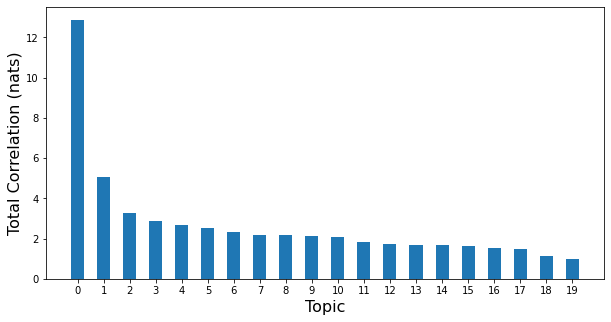

In [23]:
topic_tc_chart(topic_model)

## Anchored CorEx Topic Model 1

In [11]:
anchor_words = [['fdcpa'],['payment'],['interest','balance'],['validation','verification'],['representative','supervisor'],
                ['credit report'],['harass'],['identity theft'],['medical'],['people','family'],['statue','limitation']]

anchored_topic_model = anchored_topic_modeling(20, words, 52, doc_word, anchor_words)
anchored_topic_model

Overall Total Correlation: 67.445
0: fdcpa,follow,provide follow,obligation,pursuant,defamation,pursuant fair,constitute,party,collection activity
1: payment,late,late payment,payment plan,payment account,monthly,arrangement,monthly payment,payment arrangement,set
2: balance,interest,pay balance,balance owe,account balance,interest rate,balance account,outstanding balance,interest fee,remain balance
3: validation,verification,request,request validation,validation debt,debt validation,copy,validate,verification debt,validation request
4: representative,supervisor,tell,speak,say,ask,explain,email,contact,customer
5: credit report,report,credit,remove credit,remove,account credit,appear credit,report account,debt credit,collection credit
6: harass,call,phone,number,phone number,phone call,work,message,time,stop
7: identity theft,theft,identity,victim identity,victim,theft report,theft debt,belong identity,legal affidavit,affidavit attach
8: medical,insurance,medical bill,bill,hospital,med

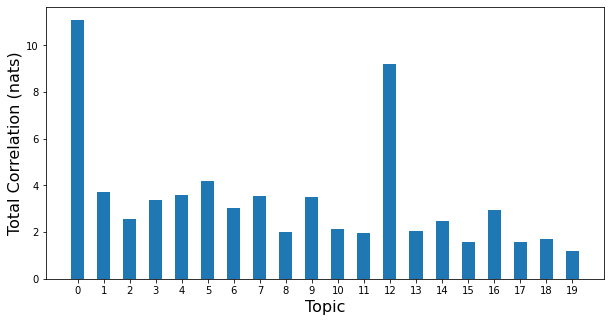

In [12]:
topic_tc_chart(anchored_topic_model)

## Anchored CorEx Topic Model 2

In [13]:
# subset of anchor words from anchor model 1 + new anchor words
anchor_words_2 = [['fdcpa','fair credit'],['payment'],['interest rate'],['validation','verification'],
                  ['representative','supervisor'],['credit report'],['harass'],['identity theft'],
                  ['wage','garnish'],['medical'],['family'],['statue','limitation']]

anchored_topic_model_2 = anchored_topic_modeling(20, words, 52, doc_word, anchor_words_2)
anchored_topic_model_2

Overall Total Correlation: 65.303
0: fair credit,act,fair,fdcpa,reporting act,fair debt,practices act,practices,collection practices,accordance
1: payment,late,late payment,payment plan,payment account,monthly,arrangement,monthly payment,payment arrangement,set
2: interest rate,fee,charge,interest,statement,matter,resolve,transfer,purchase,case
3: validation,verification,request validation,validation debt,debt validation,verification debt,validation request,validation letter,request verification,validate
4: representative,supervisor,tell,speak,say,ask,explain,email,customer,give
5: credit report,report,credit,remove credit,remove,account credit,appear credit,report account,debt credit,collection credit
6: harass,call,phone,number,phone number,phone call,work,time,message,stop
7: identity theft,theft,identity,victim identity,victim,theft report,theft debt,belong identity,legal affidavit,affidavit attach
8: wage,garnish,court,loan,serve,garnishment,county,judgement,garnish wage,firm
9: m

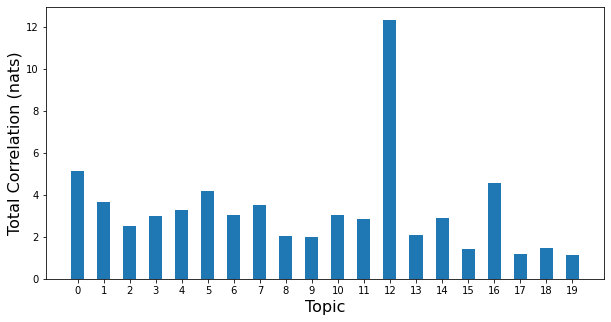

In [19]:
topic_tc_chart(anchored_topic_model_2)

## Doc-Topic Probability Matrix
#### Estimated probability of topics for each document
CorEx is a discriminative model (whereas LDA is a generative model). This means that while LDA puts out a probability distribution over each document, **CorEx instead estimates the probability a document belongs to a topic given that document's words.** As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through ```p_y_given_x``` or ```log_p_y_given_x```. 

In [20]:
doc_top_prob = pd.DataFrame(anchored_topic_model_2.p_y_given_x, columns=["topic_{}".format(i) for i in range(20)])

doc_top_prob.index = df_spacy_debt.index

doc_top_prob = pd.concat([df_spacy_debt['clean_spacy_doc2'], df_spacy_debt['Company'], doc_top_prob], axis=1)
doc_top_prob

,clean_spacy_doc2,Company,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,receive alert collections account credito...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",0.000001,0.000001,0.000005,0.000001,0.000078,0.000001,0.000001,0.000001,...,0.001367,0.000001,0.000001,0.999999,0.000034,0.000257,0.000001,0.000952,0.008204,0.000997
1,uploaded document date chase bank unlawfully...,JPMORGAN CHASE & CO.,0.000001,0.000001,0.006443,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.001844,0.000001,0.000034,0.000012,0.999999,0.000001,0.000959,0.000066,0.000144
2,pull credit report see monterey financial se...,Monterey Financial Services LLC,0.000001,0.999999,0.000197,0.999999,0.999999,0.999999,0.000002,0.000001,...,0.000001,0.999811,0.999999,0.999999,0.999999,0.000244,0.000001,0.999999,0.080337,0.999999
3,account number internet service pay outsta...,AFNI INC.,0.000001,0.999999,0.999999,0.000001,0.999999,0.000001,0.999999,0.000001,...,0.999950,0.000004,0.000001,0.999999,0.999999,0.999999,0.000001,0.000974,0.001835,0.000787
4,amcol systems debt collector report debt credi...,"AMCOL Systems, Inc.",0.000001,0.000001,0.000008,0.000001,0.000001,0.999999,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000002,0.000001,0.000001,0.000001,0.885088,0.002442,0.999993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18151,aware company place bill collection time re...,The Receivable Management Services LLC,0.000001,0.000001,0.000004,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000011,0.000001,0.000001,0.006516,0.000001,0.003111,0.000001,0.001065,0.005064,0.000534
18152,lowe advantage card online lowes.com purchase ...,SYNCHRONY FINANCIAL,0.000001,0.000001,0.999999,0.000001,0.999999,0.000001,0.999999,0.000001,...,0.999999,0.000257,0.000001,0.999962,0.001525,0.999999,0.000001,0.000971,0.161970,0.000142
18153,pay credit card get ready trip travel ...,Alliance Data Card Services,0.000001,0.999999,0.999999,0.000001,0.999999,0.000001,0.999999,0.000001,...,0.999999,0.000067,0.000001,0.999999,0.000001,0.999999,0.000001,0.999999,0.999996,0.005888
18154,sister call inform contact debt collector be...,WELLS FARGO & COMPANY,0.000001,0.999999,0.999965,0.000001,0.000022,0.000001,0.748593,0.000001,...,0.000411,0.000001,0.000001,0.000386,0.000717,0.999999,0.000001,0.000971,0.901144,0.999999


In [21]:
anchored_topic_model_2.get_top_docs(topic=8, n_docs=10)

NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


[(8970, 0.0),
 (15569, 0.0),
 (4182, 0.0),
 (11906, 0.0),
 (15597, 0.0),
 (4148, 0.0),
 (4140, 0.0),
 (11895, 0.0),
 (4119, 0.0),
 (4118, 0.0)]

In [23]:
doc_top_prob['clean_spacy_doc2'].iloc[8970]

'look night usps inform delivery horribly relevant letter date informed delivery email state receive letter know law firm hold letter attempt time respond law firm shady shady shady receive letter assume heavy usps mail activity   time technically   respond respond time frame say law firm file court case   day date letter actually receive letter law letter require -day response letter state unfortunately cancel illegal court case shady    follow law file give required law   days respond longer shady law firm     send attorney court hearing   day choice throw case love attorney think law clearly law degree    mention cfpb complaint happy pay client interest attorney fees associate want fight court want follow law fine start pay month start believe balance like pay   interest attorney fee time stop pay account stop shady bit attorney start get monthly payment account serve court court case counter sue firm monetary damage time waste cfpb shut payday loan company charge horrible fee inter